In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import models, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
f = open("data/dataset_info.txt", "r")
labels = f.readlines()[1:]
f.close()

name_label = {}
lb_list = []

for i in range(len(labels)):
    lb = labels[i].replace("\n", "").strip().split(". ")[1]
    lb_list.append(lb)
    name_label[lb] = 0
    
for i in range(len(lb_list)):
    name_label[lb_list[i]] += i
    
label_name = list(name_label.keys())


In [3]:
class LoadImageDataset(Dataset):
    def __init__(self, imgname_labels_file, img_dir, transform_data = None, typee = 'train',train = True):
        self.df_imgname_labels = pd.read_csv(imgname_labels_file)
        self.df_imgname_labels = shuffle(self.df_imgname_labels)
        if(typee == 'train'):
            self.df_imgname_labels = self.df_imgname_labels[:9000]
        if(typee == 'val'):
            self.df_imgname_labels = self.df_imgname_labels[9000:]
        
        
        self.img_dir = img_dir
        self.transform_data =  transform_data
        self.train = train
        
    def __len__(self):
        return len(self.df_imgname_labels)
    
    def __getitem__(self, idx):
        path = self.img_dir + self.df_imgname_labels.iloc[idx, 0]
        img =  read_image(path)/ 255.
        result = {"image": img, "label": -1}
        if self.train:
            lb = self.df_imgname_labels.iloc[idx, 1]
            result["label"] = lb
            if self.transform_data:
                result["label"] = self.transform_data['labels'](result["label"])
                result["image"] = self.transform_data['images'](result["image"])
        else:
            lb = 0
            result["label"] = lb
            if self.transform_data: 
                result["image"] = self.transform_data['images'](result["image"])
        
        return result

In [4]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 6),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 16),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
        )
    def forward(self, x):
        return self.model(x)

## Data Augmentation

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.4126159181859758 | val loss: 0.36366032003987314
Epoch: 2 | loss: 0.3554224430852466 | val loss: 0.3345896367318121
Epoch: 3 | loss: 0.32724791368510986 | val loss: 0.30897227713936254
Epoch: 4 | loss: 0.3049209549890624 | va

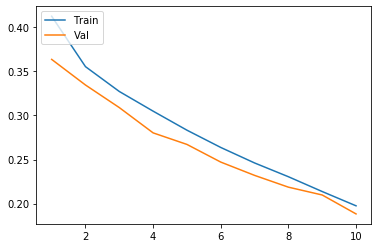

In [5]:
def train(type_optimizer= 'Adam', path = "data/", batch_size = 8, epochs = 20, transform_data_type=0):
    loss_arr = []
    val_loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
    
    if(transform_data_type == 1):
         transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomHorizontalFlip(),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y]),
                    
                ])
    }
    if(transform_data_type == 2):
         transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(),
                    
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y]),
                    
                ])
    }
    
        
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if(type_optimizer == 'Adagrad'):
        optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if(type_optimizer == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    if(type_optimizer == 'RMSprop'):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data), batch_size = batch_size,  num_workers=2, shuffle=True)
    val_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='val'), batch_size = batch_size,  num_workers=2, shuffle=True)
    loss_fun = nn.CrossEntropyLoss()
    

    for epoch in range(epochs):
        total_loss = 0
        val_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
#             print(y_preds.shape)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
           
    
        for dic in val_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)

            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            val_loss += loss.item()
        
        
        total_loss /= len(train_dataloader.dataset)
        val_loss /= len(val_dataloader.dataset)
        loss_arr.append(total_loss)
        val_loss_arr.append(val_loss)
        
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss) + " | val loss: "+str(val_loss), flush = True)
    
    return loss_arr, val_loss_arr



def plot(loss_arr, val_loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))
    plt.plot(ind, np.array(val_loss_arr))
    plt.legend(['Train', 'Val'], loc='upper left')

    
epochs = 10

loss_arr, val_loss_arr = train(type_optimizer='Adagrad', epochs = epochs)
plot(loss_arr, val_loss_arr) 

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.43949238084422215 | val loss: 0.400903162203337
Epoch: 2 | loss: 0.3886267899274826 | val loss: 0.379010749306103
Epoch: 3 | loss: 0.3670207576486799 | val loss: 0.3521950089894581
Epoch: 4 | loss: 0.35044644881619347 | val l

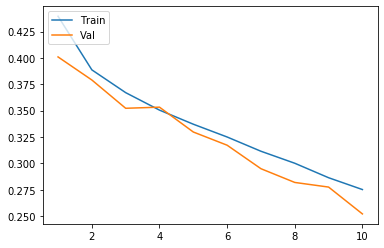

In [6]:
epochs = 10

loss_arr, val_loss_arr = train(epochs = epochs, transform_data_type=2)
plot(loss_arr, val_loss_arr) 

In [9]:
epochs = 10

loss_arr, val_loss_arr = train(epochs = epochs, transform_data_type=1)
plot(loss_arr) 

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.4365271542204751 | val loss: 0.3982473342411289
Epoch: 2 | loss: 0.38077126484447055 | val loss: 0.36448798644653413
Epoch: 3 | loss: 0.3608340067333645 | val loss: 0.32810776300105515
Epoch: 4 | loss: 0.34417700775464377 | v

TypeError: plot() missing 1 required positional argument: 'val_loss_arr'

In [12]:
loss_arr = [0.4365271542204751, 0.38077126484447055, 0.3608340067333645,  0.34417700775464377,0.33106054562330245, 0.32020702937576506, 0.30761603111690944, 0.29796573450167974, 0.28573182110653983 , 0.2744527197612657]
val_loss_arr = [0.3982473342411289, 0.36448798644653413,  0.32810776300105515, 0.32702318175289286,  0.30721694175672976,  0.31816352170318274,  0.2749770687829599, 0.2826417418825368,  0.27093223669211564, 0.2377041216605219]

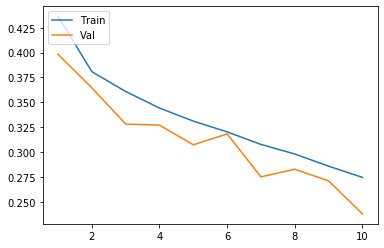

In [13]:
plot(loss_arr, val_loss_arr) 